In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import timm
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision import models

from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2

import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor, Callback
from pytorch_lightning.loggers import TensorBoardLogger

from torchmetrics.classification import MulticlassAccuracy, F1Score
!uv pip install pytorch_optimizer
import pytorch_optimizer as optim1



Using Python 3.11.13 environment at: /usr
Resolved 36 packages in 457ms                                        ⠋ Resolving dependencies...                                                     
⠙ Preparing packages... (0/1)                                                   
⠙ Preparing packages... (0/1)-----------     0 B/257.74 KiB             
⠙ Preparing packages... (0/1)----------- 16.00 KiB/257.74 KiB           
⠙ Preparing packages... (0/1)----------- 32.00 KiB/257.74 KiB           
⠙ Preparing packages... (0/1)----------- 48.00 KiB/257.74 KiB           
⠙ Preparing packages... (0/1)----------- 62.70 KiB/257.74 KiB           
⠙ Preparing packages... (0/1)----------- 78.70 KiB/257.74 KiB           
⠙ Preparing packages... (0/1)----------- 94.70 KiB/257.74 KiB           
⠙ Preparing packages... (0/1)----------- 110.70 KiB/257.74 KiB          
⠙ Preparing packages... (0/1)----------- 118.70 KiB/257.74 KiB          
⠙ Preparing packages... (0/1)----------- 134.70 KiB/257.74 KiB        

In [2]:
pl.seed_everything(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

class AlbumentationsImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=None)  # disable default transform
        self.albumentations_transform = transform

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = self.loader(path)  # default loader (PIL)
        image = np.array(image)    # PIL → NumPy
        if self.albumentations_transform:
            image = self.albumentations_transform(image=image)["image"]
        return image, label


class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Path ke direktori berisi semua gambar test.
            transform (callable, optional): Transformasi Albumentations yang akan diterapkan pada gambar.
        """
        self.root_dir = root_dir
        self.transform = transform
        allowed_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}
        self.image_files = sorted([
            f for f in os.listdir(root_dir) 
            if os.path.isfile(os.path.join(root_dir, f)) 
            and os.path.splitext(f)[1].lower() in allowed_extensions
        ])

    def __len__(self):
        """Mengembalikan jumlah total gambar dalam dataset."""
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Mengambil satu item data.

        Args:
            idx (int): Indeks dari item.
        
        Returns:
            tuple: (image_tensor, image_name)
        """
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)  # PIL → NumPy (H, W, C)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        image_name = self.image_files[idx]
        return image, image_name

In [4]:
weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
auto_transforms = weights.transforms()
print(auto_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [5]:
normz = A.Normalize(mean=(0.5, 0.5, 0.5),std=(0.5, 0.5, 0.5))
normz1 = A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

In [7]:
train_transform = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.OneOf([
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=1.0),
        A.RandomBrightnessContrast(p=1.0),
        A.HueSaturationValue(p=1.0),
        A.RandomGamma(p=1.0),
    ], p=0.7),
    A.CoarseDropout(max_holes=1, max_height=32, max_width=32, min_holes=1, fill_value=0, p=0.5),
    normz1,
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    normz1,
    ToTensorV2()
])

bs = 64
data_train = '/kaggle/input/logika/Train/Train'

train_dataset = AlbumentationsImageFolder(root=data_train, transform=train_transform)
labels = train_dataset.targets
class_counts = torch.bincount(torch.tensor(labels))
print(f"Pemetaan kelas: {train_dataset.class_to_idx}")
print(f"Jumlah sampel per kelas: {class_counts}")
class_weights = 1.0 / class_counts.float()
print(f"Bobot untuk setiap kelas: {class_weights}")
weights_per_sample = class_weights[labels]
print(f"Panjang bobot per sampel: {len(weights_per_sample)}")
print("Contoh 5 bobot pertama:", weights_per_sample[:5])

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=1, pin_memory=True)
print(f'Jumlah data test: {len(train_dataset)}')

Pemetaan kelas: {'balinese': 0, 'batak': 1, 'dayak': 2, 'javanese': 3, 'minangkabau': 4}
Jumlah sampel per kelas: tensor([776,  95,  69, 249, 563])
Bobot untuk setiap kelas: tensor([0.0013, 0.0105, 0.0145, 0.0040, 0.0018])
Panjang bobot per sampel: 1752
Contoh 5 bobot pertama: tensor([0.0013, 0.0013, 0.0013, 0.0013, 0.0013])
Jumlah data test: 1752


In [8]:
data_test_dir = '/kaggle/input/logika/Test/Test'

test_dataset = TestDataset(root_dir=data_test_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=1, pin_memory=True)
print(f'Jumlah data test: {len(test_dataset)}')

Jumlah data test: 444


In [9]:
label2cat, idxclass = train_dataset.class_to_idx, train_dataset.classes
label2cat

{'balinese': 0, 'batak': 1, 'dayak': 2, 'javanese': 3, 'minangkabau': 4}

## Arsitektur dan config

In [10]:
def conv_block(in_feature, out_feature, padding=1, stride=1,
             activation="relu", pool =True, maxpool=True, kernel_size=3,
             kernel_size_pool=2, pool_stride=2)-> list[nn.Sequential]:
    layers = [nn.Conv2d(in_feature, out_feature, kernel_size=kernel_size, padding=padding, stride=stride)]
    if activation == "relu":
        layers.append(nn.ReLU())
    elif activation == "leakyrelu":
        layers.append(nn.LeakyReLU())
    elif activation == "sigmoid":
        layers.append(nn.Sigmoid())
    elif activation == 'mish': layers.append(nn.Mish())
    elif activation == "tanh":
        layers.append(nn.Tanh())
    if pool:
        if maxpool:
            layers.append(nn.MaxPool2d(kernel_size=kernel_size_pool, stride=pool_stride))
        else:
            layers.append(nn.AvgPool2d(kernel_size=kernel_size_pool, stride=pool_stride))
    else:
        layers.append(nn.Identity())
    return nn.Sequential(*layers)


def linear_block(in_features, out_features, activation=None, dropout=0.0, batch_norm=None):
    layers = [nn.Linear(in_features, out_features)]
    if batch_norm:
        layers.append(nn.BatchNorm1d(out_features))
    if activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'sigmoid':
        layers.append(nn.Sigmoid())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'leakyrelu':
        layers.append(nn.LeakyReLU())
    elif activation == 'mish': layers.append(nn.Mish())
    elif activation == 'gelu': layers.append(nn.GELU())
    elif activation == 'silu': layers.append(nn.SiLU())
    elif activation == 'softmax':
        layers.append(nn.Softmax(dim=1))
    elif activation == 'elu':
        layers.append(nn.ELU())
    elif activation == 'selu':
        layers.append(nn.SELU())
    elif activation == 'lsoftmax':
        layers.append(nn.LogSoftmax(dim=1))
    if dropout > 0.0:
        layers.append(nn.Dropout(dropout))
    return nn.Sequential(*layers)

In [26]:
class Backbone(nn.Module):
    def __init__(self, backbone="efficientnet_b0", dropout=0.0, freeze=True):
        super().__init__()
        self.backbone_name = backbone

        if backbone == "efficientnet_b0":
            weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
            self.backbone = models.efficientnet_b0(weights=weights).features
            feature_dim = 1280
            self.needs_pooling = True

        elif backbone == "efficientformer_l1":
            self.backbone = timm.create_model("efficientformer_l1", pretrained=True, num_classes=0)
            feature_dim = 448
            self.needs_pooling = False

        else:
            raise ValueError(f"Backbone {backbone} tidak didukung")

        if freeze:
            for param in self.backbone.parameters():
                param.requires_grad = False
        else:
            print("param backbone unfreeze")
            for param in self.backbone.parameters():
                param.requires_grad = True

        self.classifier = nn.Sequential(
            linear_block(feature_dim, 512, activation='gelu', dropout=dropout, batch_norm=True),
            linear_block(512, 256, activation='gelu', dropout=dropout, batch_norm=True),
            linear_block(256, 128, activation='gelu', dropout=dropout, batch_norm=True),
            linear_block(128, 5, activation=None)
        )

    def forward(self, X):
        X = self.backbone(X)
        if self.needs_pooling: 
            X = X.mean([2, 3])
        return self.classifier(X)
        
class PL(LightningModule):
    def __init__(self, model, class_weights, learning_rate=1e-3) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
        self.macroF1 = F1Score(num_classes=5, average='macro', task='multiclass')
    
    def forward(self, X):
        return self.model(X)
    
    def _common_step(self, batch, batch_idx):
        X, labels = batch
        outputs = self(X) 
        loss = self.criterion(outputs, labels)
        macrof1 = self.macroF1(outputs, labels)
        return loss, macrof1

    def training_step(self, batch, batch_idx):
        loss, macroF1 = self._common_step(batch, batch_idx)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_macrof1', macroF1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, macroF1 = self._common_step(batch, batch_idx)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_macrof1', macroF1, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        loss, macroF1 = self._common_step(batch, batch_idx)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_macrof1', macroF1, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        backbone_params = [p for p in self.model.backbone.parameters() if p.requires_grad]
        head_params = list(self.model.classifier.parameters())
    
        optimizer = optim.AdamW([
            {"params": backbone_params, "lr": 3e-5},   
            {"params": head_params, "lr": self.hparams.learning_rate},  
        ], weight_decay=1e-4)
    
        scheduler = CosineAnnealingWarmRestarts(
            optimizer,
            T_0=5,      
            T_mult=1,   
            eta_min=1e-5 
        )

        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        """
        Langkah prediksi untuk satu batch data test.
        """
        images, image_names = batch
        outputs = self.forward(images)
        _, predicted_labels = torch.max(outputs, 1)
        return {"image_names": image_names, "preds": predicted_labels}

In [27]:
from pytorch_lightning.callbacks import Callback

class FineTuningCallback(Callback):
    def __init__(self, unfreeze_schedule, base_backbone_lr=5e-5, head_lr=1e-4, warmup_epochs=10):
        """
        unfreeze_schedule: dict {epoch: fraction_to_unfreeze}
            Contoh {1: 0.3, 5: 0.6, 10: 1.0}
        base_backbone_lr: LR maksimum backbone
        head_lr: LR classifier head
        warmup_epochs: jumlah epoch untuk naik linear dari 0 → base_backbone_lr
        """
        super().__init__()
        self.unfreeze_schedule = unfreeze_schedule
        self.base_backbone_lr = base_backbone_lr
        self.head_lr = head_lr
        self.warmup_epochs = warmup_epochs

    def on_train_epoch_start(self, trainer, pl_module):
        current_epoch = trainer.current_epoch

        # Cek apakah ada event unfreeze di epoch ini
        if current_epoch in self.unfreeze_schedule:
            fraction = self.unfreeze_schedule[current_epoch]
            backbone_layers = list(pl_module.model.backbone.children())
            n_layers = len(backbone_layers)
            cut_point = int(n_layers * (1 - fraction))

            # Freeze semua dulu
            for param in pl_module.model.backbone.parameters():
                param.requires_grad = False
            # Unfreeze sesuai fraction
            for layer in backbone_layers[cut_point:]:
                for param in layer.parameters():
                    param.requires_grad = True

            print(f"\n--- Epoch {current_epoch}: Unfreeze {fraction*100:.0f}% backbone ---")

        # Hitung LR backbone (linear warmup)
        progress = min(1.0, (current_epoch + 1) / self.warmup_epochs)
        backbone_lr = self.base_backbone_lr * progress

        # Update optimizer param groups
        optimizer = trainer.optimizers[0]
        defaults = optimizer.defaults
        param_groups = [
            {**defaults, "params": pl_module.model.backbone.parameters(), "lr": backbone_lr},
            {**defaults, "params": pl_module.model.classifier.parameters(), "lr": self.head_lr},
        ]
        optimizer.param_groups = param_groups

        print(f"LR backbone={backbone_lr:.2e} (warmup {progress*100:.0f}%), ")
        print(f"LR head={self.head_lr:.2e}")


In [28]:
import json
import yaml
import subprocess
import shutil

OUTPUT_DIR = "/kaggle/working/output_dataset"
os.makedirs(OUTPUT_DIR, exist_ok=True)

KAGGLE_USERNAME = "dimassp1"
DATASET_NAME = "efficientnet-training-output"
DATASET_SLUG = f"{KAGGLE_USERNAME}/{DATASET_NAME}"

config = {
    "architecture": "EfficientNet-B0",
    "dropout": 0.3,
    "freeze": False,
    "optimizer": "AdamW",
    "optimizer_params": {"lr": 1e-3},
    "loss_function": "CrossEntropyLoss",
    "metrics": ["F1Score_macro"],
    "epochs": 100,
    "batch_size": bs,
    "input_size": (224, 224),
    "num_classes": 5
}

OUTPUT_DIR = "/kaggle/working/output_dataset"

import os, shutil, torch, yaml, zipfile

def save_pipeline(model, checkpoint_callback, config, output_dir=OUTPUT_DIR, backbone_ratio=0.3):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    best_ckpt_path = checkpoint_callback.best_model_path
    if best_ckpt_path and os.path.exists(best_ckpt_path):
        checkpoint_file = os.path.basename(best_ckpt_path)  
        dst_path = os.path.join(output_dir, checkpoint_file)

        if os.path.abspath(best_ckpt_path) != os.path.abspath(dst_path):
            shutil.copy(best_ckpt_path, dst_path)
        else:
            print(f"ℹ️ Checkpoint sudah ada di {output_dir}, tidak perlu copy ulang.")

    else:
        print("⚠️ Best checkpoint belum ada, file .ckpt tidak disalin.")

    full_state_dict = model.state_dict()
    backbone_state_dict = {}
    backbone_keys = [k for k in full_state_dict.keys() if k.startswith("features.")]
    num_keys_to_save = max(1, int(len(backbone_keys) * backbone_ratio))

    for k in backbone_keys[:num_keys_to_save]:
        param = dict(model.named_parameters())[k]
        if param.requires_grad:
            backbone_state_dict[k] = full_state_dict[k]

    head_keys = [k for k in full_state_dict.keys() if k.startswith("classifier.")]
    for k in head_keys:
        param = dict(model.named_parameters())[k]
        if param.requires_grad:
            backbone_state_dict[k] = full_state_dict[k]

    torch.save(backbone_state_dict, os.path.join(output_dir, "efficientnet_partial_state_dict.pt"))

    with open(os.path.join(output_dir, "config.yaml"), "w") as f:
        yaml.dump(config, f)

    zip_path = os.path.join(output_dir, "output_dataset.zip")
    files_to_zip = [
        f for f in ["config.yaml", "efficientnet_partial_state_dict.pt"] 
        if os.path.exists(os.path.join(output_dir, f))
    ]
    if best_ckpt_path:
        files_to_zip.append(os.path.basename(best_ckpt_path))

    with zipfile.ZipFile(zip_path, 'w') as zipf:
        for f in files_to_zip:
            file_path = os.path.join(output_dir, f)
            zipf.write(file_path, arcname=f)

    print(f"✅ Semua output sudah di-zip: {zip_path}")
    return zip_path


In [29]:
schedule = {
    2000: 0.3,  
    1000: 0.6,   
    0: 1.0   
}

In [30]:
if torch.cuda.is_available():
    accelerator_type = 'gpu'
    devices_to_use = 1
else:
    accelerator_type = 'cpu'
    devices_to_use = 'auto'

checkpoint_callback = ModelCheckpoint(
    monitor='train_macrof1',
    dirpath=OUTPUT_DIR,
    filename='logikaui_efficientnet-{epoch:02d}-{train_macrof1:.4f}',
    save_top_k=1,
    mode='max'
)
early_stopping = EarlyStopping(
    monitor='train_loss',
    patience=15,
    mode='min',
)
lr_monitor_callback = LearningRateMonitor(logging_interval='epoch')

trainer1 = pl.Trainer(
    max_epochs=config["epochs"],
    callbacks=[checkpoint_callback, early_stopping, lr_monitor_callback],
    logger=TensorBoardLogger("tb_logs", name="efficientnet_exp"),
    accelerator=accelerator_type,
    devices=devices_to_use,
    log_every_n_steps=10,
    deterministic=True,
    # precision=16
)

## Train

In [31]:
class_weights

tensor([0.0013, 0.0105, 0.0145, 0.0040, 0.0018])

In [32]:
model = PL(Backbone(dropout=0.5, freeze=False, backbone="efficientnet_b0"), class_weights=class_weights)

param backbone unfreeze


In [33]:
from torch.serialization import add_safe_globals

add_safe_globals([Backbone, PL])  # ✅ tambahkan kelas custommu

checkpoint = torch.load(
    "/kaggle/input/train-logika/logikaui_efficientnet-epoch01-train_macrof10.9504.ckpt",
    map_location="cpu",
    weights_only=False
)
model.load_state_dict(checkpoint["state_dict"])


<All keys matched successfully>

In [ ]:
# trainer1.fit(model, train_loader, val_dataloaders=None, ckpt_path=None)

In [ ]:
# zip_path = save_pipeline(model, checkpoint_callback, config, output_dir=OUTPUT_DIR, backbone_ratio=0.3)
# print("Zip file:", zip_path)

In [34]:
if __name__ == "__main__":
    preds = trainer1.predict(model, test_loader, ckpt_path=None)
    print(preds)

2025-09-30 12:15:35.849720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759234536.193198      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759234536.297973      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Predicting: |          | 0/? [00:00<?, ?it/s]

[{'image_names': ('Test_001.jpg', 'Test_002.jpg', 'Test_003.jpg', 'Test_004.jpg', 'Test_005.jpg', 'Test_006.jpg', 'Test_007.jpg', 'Test_008.jpg', 'Test_009.jpg', 'Test_010.jpg', 'Test_011.jpg', 'Test_012.jpg', 'Test_013.jpg', 'Test_014.jpg', 'Test_015.jpg', 'Test_016.jpg', 'Test_017.jpg', 'Test_018.jpg', 'Test_019.jpg', 'Test_020.jpg', 'Test_021.jpg', 'Test_022.jpg', 'Test_023.jpg', 'Test_024.jpg', 'Test_025.jpg', 'Test_026.jpg', 'Test_027.jpg', 'Test_028.jpg', 'Test_029.jpg', 'Test_030.jpg', 'Test_031.jpg', 'Test_032.jpg', 'Test_033.jpg', 'Test_034.jpg', 'Test_035.jpg', 'Test_036.jpg', 'Test_037.jpg', 'Test_038.jpg', 'Test_039.jpg', 'Test_040.jpg', 'Test_041.jpg', 'Test_042.jpg', 'Test_043.jpg', 'Test_044.jpg', 'Test_045.jpg', 'Test_046.jpg', 'Test_047.jpg', 'Test_048.jpg', 'Test_049.jpg', 'Test_050.jpg', 'Test_051.jpg', 'Test_052.jpg', 'Test_053.jpg', 'Test_054.jpg', 'Test_055.jpg', 'Test_056.jpg', 'Test_057.jpg', 'Test_058.jpg', 'Test_059.jpg', 'Test_060.jpg', 'Test_061.jpg', 'Test_

In [35]:
predictions = []
for batch_result in preds:
    image_names = batch_result['image_names']
    preds = batch_result['preds'].cpu().numpy() 
    
    for name, label in zip(image_names, preds):
        predictions.append({
            'id': name,     
            'style': label  
        })
predictions

[{'id': 'Test_001.jpg', 'style': 0},
 {'id': 'Test_002.jpg', 'style': 4},
 {'id': 'Test_003.jpg', 'style': 4},
 {'id': 'Test_004.jpg', 'style': 0},
 {'id': 'Test_005.jpg', 'style': 0},
 {'id': 'Test_006.jpg', 'style': 0},
 {'id': 'Test_007.jpg', 'style': 0},
 {'id': 'Test_008.jpg', 'style': 0},
 {'id': 'Test_009.jpg', 'style': 3},
 {'id': 'Test_010.jpg', 'style': 4},
 {'id': 'Test_011.jpg', 'style': 3},
 {'id': 'Test_012.jpg', 'style': 1},
 {'id': 'Test_013.jpg', 'style': 4},
 {'id': 'Test_014.jpg', 'style': 0},
 {'id': 'Test_015.jpg', 'style': 0},
 {'id': 'Test_016.jpg', 'style': 4},
 {'id': 'Test_017.jpg', 'style': 4},
 {'id': 'Test_018.jpg', 'style': 3},
 {'id': 'Test_019.jpg', 'style': 0},
 {'id': 'Test_020.jpg', 'style': 1},
 {'id': 'Test_021.jpg', 'style': 0},
 {'id': 'Test_022.jpg', 'style': 1},
 {'id': 'Test_023.jpg', 'style': 0},
 {'id': 'Test_024.jpg', 'style': 0},
 {'id': 'Test_025.jpg', 'style': 4},
 {'id': 'Test_026.jpg', 'style': 4},
 {'id': 'Test_027.jpg', 'style': 0},
 

In [36]:
submission_df = pd.DataFrame(predictions)

In [37]:
class_mapping = {'balinese': 0, 'batak': 1, 'dayak': 2, 'javanese': 3, 'minangkabau': 4}
idx_to_class = {v: k for k, v in class_mapping.items()}
print(f"Tipe data kolom 'style': {submission_df['style'].dtype}")
submission_df['id'] = submission_df['id'].str.split('.').str[0]

print(f"Nilai unik di kolom 'style': {submission_df['style'].unique()}")
submission_df['style'] = submission_df['style'].map(idx_to_class)
submission_df.head()

Tipe data kolom 'style': int64
Nilai unik di kolom 'style': [0 4 3 1 2]


,id,style
0,Test_001,balinese
1,Test_002,minangkabau
2,Test_003,minangkabau
3,Test_004,balinese
4,Test_005,balinese


In [38]:
submission_df.to_csv('submissio1.csv', index=False)

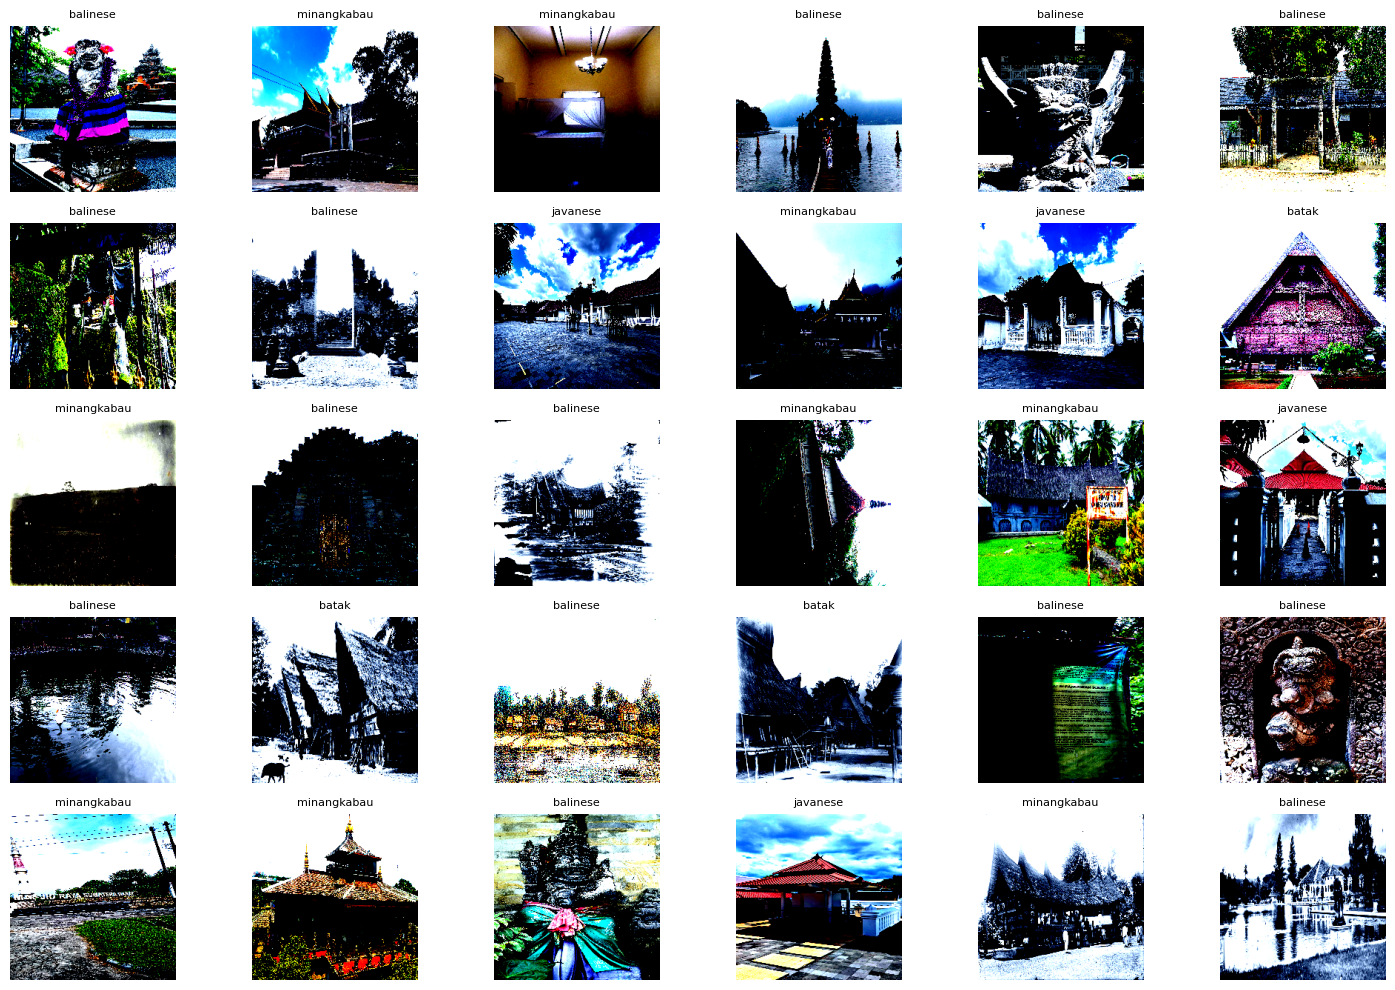

In [40]:
import matplotlib.pyplot as plt

images_shown = 0
plt.figure(figsize=(15, 10))

for images, labels in test_loader:   # ganti test_loader sesuai dataloader kamu
    for j in range(images.size(0)):
        if images_shown >= 30:   # tampilkan 30 gambar
            break

        images_shown += 1
        plt.subplot(5, 6, images_shown)   # grid 5x6
        plt.axis("off")

        # ambil image + denormalisasi
        img = images[j].cpu().permute(1, 2, 0).numpy()
        # img = img * 0.5 + 0.5   # undo normalize (mean=0.5, std=0.5)
        img = img.clip(0, 1)

        plt.imshow(img)

        # ambil label
        label = submission_df['style'][j]
        plt.title(label, fontsize=8)

    if images_shown >= 30:
        break

plt.tight_layout()
plt.show()
